# Estimation of thermodynamic constants for *i*CH360

In [64]:
import cobra
import pandas as pd
import numpy as np
from equilibrator_api import ComponentContribution,Q_,Reaction
from equilibrator_assets.local_compound_cache import LocalCompoundCache
import importlib
import pickle
from scipy.linalg import block_diag,lstsq
import sys
sys.path.append('../../utils')
from EQuilibrator_utils import LINALG
import matplotlib.pyplot as plt
import EQuilibrator_utils as EQuilibrator_utils
import cvxpy


## Read the custom EQuilibrator compound cache
We constructed this custom-made EQuilibrator cache to enable estimation of thermodynamic constants for those reactions involving those "tricky" metabolites containing protein side groups (for example, ACP-bounds fatty acids in the fatty acid biosynthesis pathway). Particularly, we constructed the cache by extending the original EQuilibrator cache with a range of metabolites in which protein side groups are replaced with a decomposable side group chosen to match the natural chemical environment for that molecule. Please refer to [notes_on_the_estimation_pipeline.md](./notes_on_the_estimation_pipeline.md) for more details about this.



In [65]:
lc=LocalCompoundCache()
lc.load_cache('data/custom_compounds_cache.sqlite')
#create a component-contribution object based on this cache
cc=ComponentContribution(ccache=lc.ccache)

No valid license for cxcalc installed, operating in read-only mode. A local cache may be loaded, but no compounds can be created. Please obtain a ChemAxon license to enable compound creation.
Loading compounds from data/custom_compounds_cache.sqlite


## Parse a list of target reactions (and associated metabolites) from the metabolic model

In [66]:
#Load cobra model
model=cobra.io.read_sbml_model('../../Model/iCH360/Escherichia_coli_iCH360.xml') 
model_pp=model.copy() # for preprocessing
#remove free protons (They only affect )
model_pp.remove_metabolites([model_pp.metabolites.get_by_id('h_'+c) for c in ('c','p','e')],destructive=False)
#Create function the filter out reactions we don't want to include in the estimation
def rxn_filter(r):
    if 'EX_' in r.id:
        return False
    elif r.id == 'Biomass':
        return False
    elif 's0001' in r.gene_reaction_rule:
        return False
    else:
        return True    
target_rxns=[r for r in model_pp.reactions if rxn_filter(r)]

#make a unique list of metabolites involved in the target reactions
target_metabolites=[]
for r in target_rxns:
    target_metabolites+=list(r.metabolites.keys())

target_metabolites=set(target_metabolites)
compartment_metabolites=set(target_metabolites)
target_metabolites_bigg=set([m.id[0:-2] for m in target_metabolites]) #remove compartments and duplicates


print(f'{len(target_rxns)} target reactions remained after filtering, containing {len(target_metabolites_bigg)} unique metabolites ({len(compartment_metabolites)} compartemnt-specifific metabolites)')




312 target reactions remained after filtering, containing 253 unique metabolites (299 compartemnt-specifific metabolites)


## Estimating Gibbs fre energies of reaction $\Delta_rG^0$
The notation and maths in this section are based on the Supplementary Information of 

Beber, M. E. et al. eQuilibrator 3.0: a database solution for thermodynamic constant estimation. Nucleic Acids Research 50, D603–D609 (2022).

### Extracting the "under-the-hood" training Matrices from EQuilibrator

In [67]:
# this is a system parameter (you can think about it as the prior of the uncertainty)
MSE_inf = 1e10
#Number of compounds in the training dataset
Nc = cc.predictor.params.dimensions.at["Nc", "number"]

# Number of "real" groups
Ng = cc.predictor.params.dimensions.at["Ng", "number"]
#Number of fake groups (non-decomposable compounds)
N_fg=cc.predictor.params.dimensions.at["Ng_full", "number"]-Ng

#Train matrices DataFrames
G_df=cc.predictor.params.train_G.copy()
S_df=cc.predictor.params.train_S.copy()
# observed ΔG0_r
b = cc.predictor.params.train_b 

### Augment the G matrix with the compounds not found in the training set (construct the $G^{'}$ matrix )

In [69]:
#This is a map between metabolites in the model and the of their replacement in the local cache (e.g. octACP -> ocPPT)
acp_to_ppt_map=pd.read_csv('acp_replacements/PPT_acp_replacements_df.csv').filter(['coco_id','bigg_ACP_equivalent']).set_index('bigg_ACP_equivalent').squeeze()
acp_to_ppt_map.tail()

bigg_ACP_equivalent
t3c11vaceACP         t3c11vacePPT
octeACP                   octePPT
ACP                        PPTCH3
grxrd           grxrd_active_site
grxox           grxox_active_site
Name: coco_id, dtype: object

In [70]:
#Preliminaries---------------------
#Extended G matrxix with new compounds
G_prime_df=pd.DataFrame(columns=G_df.columns)
#augmentation vector corresponding to each column we added to the G matrix
#--------------------------
# Loop through all ACP-free compounds in the manually-curated decomposition table:
for bigg_id_w_acp,coco_id_w_sch3 in acp_to_ppt_map.items():
    #retrieve group vector
    gv=cc.get_compound(f'coco:{coco_id_w_sch3}').group_vector.copy()
    #augment it with zeros to account for a) the pseudocompounds in G and b) the new groups we added to G
    gv+=[0]*N_fg #fake groups in G
    #add the group names as index
    gvs=pd.Series(index=G_prime_df.columns,data=gv)
    #Check dimension are consistent
    assert(len(gvs)==G_df.shape[1])
    assert(not (gvs<0).any())
    assert(gvs.shape[0]==G_prime_df.shape[1]) #Sanity check to ensure we are not spuriously adding groups
    G_prime_df.loc[bigg_id_w_acp]=gvs

#Now, let's add the free ACP species
empty_gv=gv=pd.Series(index=G_prime_df.columns,
                      data=[0]*G_prime_df.shape[1])

#Preview the group incidence matrix extended with new compounds (G')
G_prime_df.tail()

,primary -Cl3 [H0 Z0 Mg0],primary -Cl2 [H0 Z0 Mg0],secondary -Cl2 [H0 Z0 Mg0],primary -Cl [H0 Z0 Mg0],secondary -Cl [H0 Z0 Mg0],tertiary -Cl [H0 Z0 Mg0],ring -Cl [H0 Z0 Mg0],ring -Br [H0 Z0 Mg0],ring -I [H0 Z0 Mg0],ring -F [H0 Z0 Mg0],...,"Compound(id=4187, inchi_key=RAHZWNYVWXNFOC-UHFFFAOYSA-N)","Compound(id=81378, inchi_key=LSNNMFCWUKXFEE-UHFFFAOYSA-L)","Compound(id=101, inchi_key=IOVCWXUNBOPUCH-UHFFFAOYSA-M)","Compound(id=104, inchi_key=CWYNVVGOOAEACU-UHFFFAOYSA-N)","Compound(id=748, inchi_key=ROSDSFDQCJNGOL-UHFFFAOYSA-O)","Compound(id=621, inchi_key=JLVVSXFLKOJNIY-UHFFFAOYSA-N)","Compound(id=110, inchi_key=XSQUKJJJFZCRTK-UHFFFAOYSA-N)","Compound(id=241, inchi_key=None)","Compound(id=242, inchi_key=BAVYZALUXZFZLV-UHFFFAOYSA-O)","Compound(id=9721, inchi_key=None)"
t3c11vaceACP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
octeACP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
grxrd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
grxox,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### A few useful functions to retrieve metabolites from the cache

In [71]:
# Load manual curation data ===============
#Manual decompositions
with open('data/manual_decompositions.pkl','rb') as file:
    manual_decompositions=pickle.load(file)

#hard mappings between bigg ids and equilibrator compounds
bigg2eq_hard_mappings=pd.read_csv('data/bigg2equilibrator_manual_map.csv').set_index('bigg_id')
#===========================================
#============================================

#some helpful functions for later
def retrieve_metabolite(bigg_id):
    '''
    retrieve compound in equilibrator, if available, by accounting for the manually curated hard-mappings and the custom created ACP-compound cache
    '''
    eq_name=f'bigg.metabolite:{bigg_id}'
    return cc.get_compound(eq_name)

def retrieve_group_vector(bigg_id):
    '''
    Retrieve group vector by searching in manual curation or EQuilibrator
    '''
    if bigg_id in manual_decompositions.keys():
        gv= manual_decompositions[bigg_id].values.tolist()
    elif cc.get_compound(f'bigg.metabolite:{bigg_id}') is not None:
        gv=cc.get_compound(f'bigg.metabolite:{bigg_id}').group_vector
    if  (gv==[]):
        return None
    else:
        return gv
def check_if_cpd_is_in_training_set(bigg_id,G_df):
    cpd=cc.get_compound(f'bigg.metabolite:{bigg_id}')
    if cpd is None:
        return (False,None)
    else:
        id=cpd.id
    return (id in G_df.index,id)

Some metabolites are not part of the G matrix, since they are part of the training set. Here, we split the target metabolites in the model between those in the training set and those not into it. This will be important in the next section to produce the $X$ and $X'$ matrices.

In [72]:
#keep track of training vs non training metabolites for future use
mets_in_training_set=[]
new_mets=[] 
#Iterate through target metabolites
for m in target_metabolites_bigg:
    met_id=m #exclude the compartment from the id
    if met_id in G_prime_df.index:
        #We already added this compound in the previous steps
        new_mets.append(met_id)
        continue
    elif check_if_cpd_is_in_training_set(met_id,G_df)[0]:
        #print(f'{met_id} already in the training set') 
        mets_in_training_set.append(met_id)
        continue
    #Try to retrieve the group vector
    #print(f'Metabolite {met_id} not found in training set/or in G_prime matrix')
    gv=retrieve_group_vector(bigg_id=met_id)
    if gv is None:
        print(f'Unable to retrieve decomposition for {met_id}. Discarding it')
    else:
        if len(gv)!=Ng:
            print(f'The group vector for {met_id} is longer than it should and will be discarded ({len(gv)} groups instead of {Ng}). Please fix the problem with with either a hard-mapping or a manual decomposition')
            continue
        #Aument group vector with fake groups + new gorups
        gv_full=gv+[0]*N_fg
        #Add index
        gv_full_series=pd.Series(index=G_prime_df.columns,data=gv_full)
        #Add row to G'
        G_prime_df.loc[met_id]=gv_full_series
        #Store for future use
        new_mets.append(met_id)


In [73]:
#Check we didn't lose metabolites in the process
assert len(new_mets+mets_in_training_set)==len(target_metabolites_bigg) 

### Construct stoichiometric Matrix of Target Reactions
Now, we construct the stoichiometric matrix of target reactions, $\bar{X}$, Eq. 4. This matrix is itself composed of two submatrices:
$$\bar{X}=\begin{bmatrix}X \\ X'\end{bmatrix}$$
where:
- $X$ contains all metabolites in the training set (even if they are not used by any of the target reactions), and has therefore the same number of rows as the training matrices $S$ and $G$
- $X'$ contains all the new metabolites, and therefore has the same number of rows as the matrix $G'$

In [74]:
#Initialise matrix with right dimensions
X_r=pd.DataFrame(index=G_df.index,columns=[r.id for r in target_rxns])
X_r_prime=pd.DataFrame(index=G_prime_df.index,columns=[r.id for r in target_rxns])
#Replace NaN with zeros
X_r=X_r.replace(np.nan,0)
X_r_prime=X_r_prime.replace(np.nan,0)

#Track successfully found reactions
success_reactions=[]
#Loop through each target reaction, and fill in the matrix
for r in target_rxns:
    stoichiometry=r.metabolites

    
    success=True
    for met,stoich in stoichiometry.items():
        met_id=met.id[0:-2] #get_rid of compartment
        if met_id in new_mets:
            #If met belongs to the new metabolites, we add it to X'
            X_r_prime.loc[met_id,r.id]+=stoich
        elif check_if_cpd_is_in_training_set(bigg_id=met_id,G_df=G_df)[0]:
            #If met belongs to the training set, map it to the correct index in the training set and add it to X
            ix_in_training_set=check_if_cpd_is_in_training_set(bigg_id=met_id,G_df=G_df)[1]
            X_r.loc[ix_in_training_set,r.id]+=stoich
        else:
            #Something went wrong!
            print(f"Metabolite {met_id} in reaction {r.id} wasn't found in either the training set or the new metabolites. {r.id} will be discarded from the estimation")
            success=False

    if success:
        success_reactions.append(r.id)


#Reindex the matrix columns to accounts for any reaction we dropped in the process
X_r=X_r[success_reactions]
X_r_prime=X_r_prime[success_reactions]

#Construct X_bar (this is more for book-keeping, we don't actiually use it
X_r_bar=pd.concat([X_r,X_r_prime],axis=0)

In [75]:
X_r.head()

,NDPK5,SHK3Dr,NDPK6,NDPK8,DHORTS,OMPDC,G5SD,CS,ICDHyr,ACALD,...,EAR80x,3OAR180,3OAS180,3HAD180,NADH16pp,NADH17pp,VPAMTr,PIt2rpp,PItpp,SUCCt1pp
5,0,0,0,0,-1,0,0,-1,0,0,...,0,0,0,1,0,0,0,0,0,0
6,-1,0,-1,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,1,0,-1,0,...,0,1,0,0,0,0,0,0,0,0
9,0,-1,0,0,0,0,-1,0,1,0,...,0,-1,0,0,0,0,0,0,0,0


In [76]:
X_r_prime.head()

,NDPK5,SHK3Dr,NDPK6,NDPK8,DHORTS,OMPDC,G5SD,CS,ICDHyr,ACALD,...,EAR80x,3OAR180,3OAS180,3HAD180,NADH16pp,NADH17pp,VPAMTr,PIt2rpp,PItpp,SUCCt1pp
malACP,0,0,0,0,0,0,0,0,0,0,...,0,0,-1,0,0,0,0,0,0,0
acACP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
actACP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3haACP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
but2eACP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Estimate $\Delta_rG^0$


In [77]:
v_r,v_g,C,Lq=EQuilibrator_utils.compute_preprocessing_vectors(G=G_df.values,
                                                              S=S_df.values,
                                                              b=b)

In [78]:
#Mean (Eq. 8)
drg0_mean = X_r.values.T@v_r + X_r_prime.values.T @ G_prime_df.values @ v_g
drg0_mean_df=pd.Series(index=X_r_bar.columns,data=drg0_mean,name='drg0_mean')

#DrG0 covariance estimate (Eq. 11)
H=np.vstack([X_r.values, G_prime_df.values.T @ X_r_prime.values])
drg0_cov = H.T @ C @ H
drg0_cov_df=pd.DataFrame(index=X_r_bar.columns,columns=X_r_bar.columns,data=drg0_cov)

#Square root (Eq. 13/14)
Q=(X_r_bar.T).values@\
  block_diag(np.eye(X_r.shape[0]),G_prime_df.values)@\
  Lq
Q_fcr=LINALG.qr_rank_deficient(Q.T).T
Q_df=pd.DataFrame(index=drg0_cov_df.index,data=Q_fcr)

In [79]:
drg0_mean_df.to_csv('../free_energy_estimates/drg0_estimates/drg0_mean_df.csv')
drg0_cov_df.to_csv('../free_energy_estimates/drg0_estimates/drg0_cov_df.csv', index=True)
Q_df.to_csv('../free_energy_estimates/drg0_estimates/drg0_cov_sqrt.csv',index=True)

### Verify that the custom estimates matches the one produced by the EQuilibrator API for the reactions in the database (this may take a while since we are using a locally generated cache)

In [80]:
from equilibrator_api import Reaction

eq_reactions=[] #reactions in the target set that can be computed by equilbrator
eq_reactions_ids=[]

#helper function to flag reactions in EQuilibrator but with infinite uncertainty
def equilibrator_uncertainty_is_too_high(eq_rxn,thresh=1e5):
    dg_mean,dg_var=cc.standard_dg_prime_multi([eq_rxn])
    if dg_var.m_as("kJ**2/mol**2")[0,0]>=thresh:
        return True
    else:
        return False
# Loop through target reactions and parse those for which all compounds are in EQuilibrator/have an inchi
for r in target_rxns:
    stoichiometry=r.metabolites
    cpds_ids=[met.id for met in r.metabolites.keys()]
    eq_compounds={c_id:retrieve_metabolite(c_id[0:-2]) for c_id in cpds_ids}
    if np.any([x is None for x in eq_compounds.values()]):
        continue
    elif np.any([x.inchi is None for x in eq_compounds.values()]):
        continue
    else:
        #initialise reaction dict
        cur_rxn={eq_compounds[met.id]:0 for met,s in r.metabolites.items()}
        #fill with stoichiometry
        for met,s in r.metabolites.items():
            cur_rxn[eq_compounds[met.id]]+=s
        eq_reaction=Reaction(cur_rxn)
        if equilibrator_uncertainty_is_too_high(eq_reaction,thresh=1e9):
            continue
        else:
            eq_reactions_ids.append(r.id)
            eq_reactions.append(eq_reaction)
print(f'Only {len(eq_reactions_ids)} reactions out of {len(target_rxns)} were found and computed directly through the EQuilibrator API')
#Compute free enerhies directly from equilibrator (to be used as a benchmark to check our estimates)
benchmark_dgr0_mean, benchmark_dgr0_cov = cc.standard_dg_multi(
    eq_reactions, uncertainty_representation="cov"
)
benchmark_dgr0_mean=benchmark_dgr0_mean.m_as("kJ/mol")
benchmark_dgr0_mean_df=pd.Series(index=eq_reactions_ids,data=benchmark_dgr0_mean)

benchmark_dgr0_cov=benchmark_dgr0_cov.m_as("kJ**2/mol**2")
benchmark_dgr0_cov_df=pd.DataFrame(index=eq_reactions_ids,columns=eq_reactions_ids,data=benchmark_dgr0_cov)

Only 239 reactions out of 312 were found and computed directly through the EQuilibrator API


[None, None]

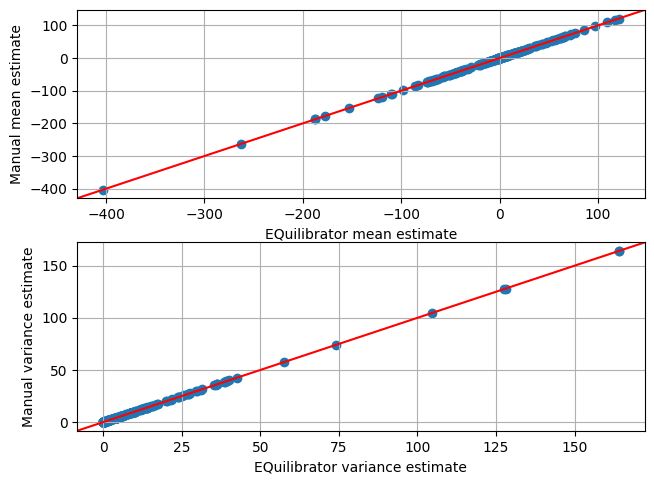

In [81]:
# Compare our estimates to the one found by equilibrator. Make sure they are indexed by the same index
#1. mean =======================
manual_estimates=drg0_mean_df[eq_reactions_ids].values #subset of our estimates that is also found in equilibrator
equilibrator_estimates=benchmark_dgr0_mean_df[eq_reactions_ids].values #benchmark values

#2. Variance
#benchmark variance
manual_variance=np.diag(drg0_cov_df.loc[eq_reactions_ids,eq_reactions_ids].values)
eq_estimates_variance=np.diag(benchmark_dgr0_cov_df.loc[eq_reactions_ids,eq_reactions_ids].values)

fig,ax=plt.subplots(2)
plt.tight_layout()


ax[0].scatter(equilibrator_estimates,manual_estimates)
for r_id,x,y in zip(eq_reactions_ids,equilibrator_estimates,manual_estimates):
    if np.abs(x-y)>10:
        plt.text(x,y,r_id, va='bottom', ha='center')

ax[0].set_xlabel('EQuilibrator mean estimate')
ax[0].set_ylabel('Manual mean estimate')
#

ax[1].scatter(eq_estimates_variance,manual_variance)
for r_id,x,y in zip(eq_reactions_ids,eq_estimates_variance,manual_variance):
    if np.abs(x-y)>10:
        plt.text(x,y,r_id, va='bottom', ha='center')

ax[1].set_xlabel('EQuilibrator variance estimate')
ax[1].set_ylabel('Manual variance estimate')

[ax[i].axline((1, 1), slope=1,c='red') for i in range(len(ax))]
[ax[i].grid() for i in range(len(ax))]






# Computing Legendre Transform to obtain *transformed* standard Gibbs free enrgies of reaction ($\Delta_rG'^{\circ}$)

In [82]:
lc_legendre_transform=LocalCompoundCache()
lc_legendre_transform.load_cache('data/custom_compounds_cache.sqlite')
cc_lt=ComponentContribution(ccache=lc_legendre_transform.ccache)

No valid license for cxcalc installed, operating in read-only mode. A local cache may be loaded, but no compounds can be created. Please obtain a ChemAxon license to enable compound creation.
Loading compounds from data/custom_compounds_cache.sqlite


In [83]:
compartments_data=pd.read_csv('data/e_coli_compartment_parameters.csv').set_index('Compartment')
compartments_data

,pH,pMg,I,phi,T
Compartment,,,,,
e,6.90,3.0,0.1,0.000,310.15
p,6.91,3.0,0.1,-0.001,310.15
c,7.80,3.0,0.1,-0.086,310.15


In [84]:
#Create stoichiometruc matrix for the model
ich360_S=cobra.util.array.create_stoichiometric_matrix(model,'DataFrame')
ich360_S=ich360_S.loc[[m.id for m in compartment_metabolites],[r.id for r in target_rxns]]

In [85]:
replacements=pd.read_csv('./acp_replacements/PPT_acp_replacements_df.csv').set_index('bigg_ACP_equivalent').loc[:,'coco_id']
replacements.head()

bigg_ACP_equivalent
malACP        malPPT
acACP          acPPT
actACP        actPPT
3haACP        3haPPT
but2eACP    but2ePPT
Name: coco_id, dtype: object

In [86]:
eq_compounds_for_lt=dict()
for m_id in ich360_S.index:
    comp_free_id=m_id[0:-2]
    if comp_free_id in replacements.index:
        id=replacements.loc[comp_free_id]
        namespace='coco'
    else:
        id=comp_free_id
        namespace='bigg.metabolite'
    try:
        cpd=cc_lt.get_compound(f'{namespace}:{id}')
        if cpd is None:
            print(f'Unable to find {comp_free_id}')
        eq_compounds_for_lt[comp_free_id]=cpd
    except:
        print(f'Unable to retrieve {comp_free_id}')


                              


In [87]:
import tqdm
eps_l_dict = dict()
for m_id in tqdm.tqdm(ich360_S.index):
    m=model.metabolites.get_by_id(m_id)
    cur_compartment=m.compartment
    cur_compartment_data=compartments_data.loc[cur_compartment]
    T=Q_(cur_compartment_data['T'],'K')
    pH=Q_(cur_compartment_data['pH'])
    pMg=Q_(cur_compartment_data['pMg'])
    I=Q_(cur_compartment_data['I'],'M')
    comp_free_id=m_id.replace(f'_{cur_compartment}','')    
    cpd=eq_compounds_for_lt[comp_free_id]
    try:
        transform=cpd.transform(temperature=T,p_h=pH,p_mg=pMg,ionic_strength=I).m_as('kJ/mol')
    except:
        print(f'Unable to compute transform for {comp_free_id}. Setting eps_l to 0 for this compound')
        transform=0
    eps_l_dict[m.id]=transform
eps_l=pd.Series(eps_l_dict)
assert np.all((ich360_S.index==eps_l.index))
eps_l


100%|██████████| 299/299 [08:32<00:00,  1.71s/it]


pyr_p           124.075929
dttp_c          618.615617
o2_c              0.000000
lys__L_c        703.310933
tdec2eACP_c    1876.911753
                  ...     
xyl__D_e        415.986723
lac__D_c        234.021522
grxrd_c        1495.460126
g6p_c           513.614446
trdrd_c         890.894618
Length: 299, dtype: float64

In [88]:
drg0_prime_mean_df=drg0_mean_df.loc[ich360_S.columns]+ ich360_S.T@eps_l

In [89]:
drg0_prime_mean_df.to_csv('../free_energy_estimates/drg0_estimates/drg0_prime_mean.csv')
(ich360_S.T@eps_l).to_csv('../free_energy_estimates/drg0_estimates/legendre_corrections.csv')
eps_l.to_csv('../free_energy_estimates/drg0_estimates/eps_l.csv')

# Norm minimization for estimates with infinite uncertainty
For reaction without available information, the Component contribution approach will assign an arbitrarily high uncertainty. In practice, this infinite uncertainty implies that there exist a subspace of the reaction energy space along which the mean estimate can be moved freely based on the available information. By a regularisation argument, we'd like to move our mean estimate along this subspace so as to minimize its norm (in the absence of any information, the minimum norm estimate is preferred as a mean). Mathematically, let:

$\Sigma_{\Delta_rG^0} = VEV^T$ 

be the eigendecomposition of the covariance ,matrix, and let $V_{\infty}$ be the submatrix of V corresponding to "infinite" eigenvalues (from a numerical perspective, higher than a chosen threshold). Then our mean vector $\Delta_rG^0$ can be any vector of the form:

$\Delta_rG^0=\mu +V_{\infty}m$

where $\mu$ is the mean estimate we computed and $m$ is a free parameter vector.

The value of $m$ the minimizes $||\Delta_rG^0||^2$ is, by definition, the least square solution to the overdetermined system $V_{\infty}m=-\mu$, that is $-V_{\infty}^+ \mu$, hence the minimum norm mean_vector is given by:

$\Delta_rG^0 (min)=\mu -V_{\infty}V_{\infty}^+ \mu =(I-V_{\infty}V_{\infty}^+)\mu$


In [90]:
from scipy.linalg import block_diag,svd,pinv
def minimize_norm(mean_df,cov_df,sv_inf_thresh=1e6):
    #Compute svd of covariance (Note that this is equivalent to eigendecomposition for a symmetry PD matrix)
    U,Sigma,V=svd(cov_df.values)
    #Identify singular values above the infinity threshold to determine dimentions with infinite uncertainty
    ix_inf=np.nonzero(Sigma>=sv_inf_thresh)[0]
    V_inf=U[:,ix_inf] #Basis for the infinite uncertainty subspace
    V_inf_pinv=pinv(V_inf)

    mean_norm_minimized=mean_df.values-(V_inf@V_inf_pinv@mean_df.values)
    comparison_df=pd.DataFrame(index=mean_df.index,columns=['mean_raw','mean_norm_minimized','abs_diff','std_raw'])
    comparison_df['mean_raw']=mean_df.values
    comparison_df['mean_norm_minimized']=mean_norm_minimized
    comparison_df['abs_diff']=np.abs(mean_df.values-mean_norm_minimized)
    comparison_df['std_raw']=np.sqrt(np.diag(cov_df.values))

    mean_norm_minimised_df=comparison_df['mean_norm_minimized']
    return mean_norm_minimised_df, comparison_df
    
drg0_prime_mean_nm_df,comparison_df=minimize_norm(mean_df=drg0_prime_mean_df,cov_df=drg0_cov_df)
comparison_df.sort_values(by='abs_diff',ascending=False).head(15)

,mean_raw,mean_norm_minimized,abs_diff,std_raw
GMPS2,-342.216208,-1.614324e-07,342.216208,67656.964759
PRAMPC,-315.421910,-4.441042e+01,271.011492,59929.536455
IG3PS,226.601073,-4.441042e+01,271.011489,59929.536473
RNDR2b,82.705755,-9.600193e+00,92.305948,200000.001424
RNDR1b,78.547976,-1.375797e+01,92.305947,200000.001434
GRXR,-115.664112,-2.335816e+01,92.305947,200000.001405
PRFGS,26.365618,1.124986e+01,15.115755,48207.299067
PRAIS,-3.865890,1.124986e+01,15.115754,48207.299538
DHQS,-151.006499,-1.510065e+02,0.000002,6.264637
P5CR,-9.474895,-9.474893e+00,0.000002,6.029368


In [91]:
drg0_prime_mean_nm_df.to_csv('../free_energy_estimates/drg0_estimates/drg0_prime_mean_norm_minimised.csv')

# Multi-compartment Correction
For this, we use the model which include protons

In [92]:
S_w_protons=cobra.util.array.create_stoichiometric_matrix(model,'DataFrame').loc[:,[r.id for r in target_rxns]]

In [93]:
# Physical and mathematical constants.

#The gas constant
R = Q_(8.31446261815324e-3, "kJ / mol / K")

#Faraady's constant
F = Q_(96.48533212, "kC / mol")

#Temperature
T = Q_(310, "K")
LOG10=np.log(10)
constants={'R':R,'F':F,'T':T}


In [94]:
metabolites=model.metabolites
def get_nH(metabolite):
    if 'H' in metabolite.elements.keys():
        return metabolite.elements['H']
    else:
        return 0
nH = np.array([get_nH(m) for m in metabolites])
z = np.array([m.charge for m in metabolites])
pH = np.array([compartments_data.loc[m.compartment,'pH'] for m in metabolites])
phi =Q_(np.array([compartments_data.loc[m.compartment,'phi'] for m in metabolites]),
        'V')

pH_correction = -R * T * LOG10 * pH * nH
phi_correction = F * phi * z

eps_mc=(pH_correction+phi_correction).m_as('kJ/mol')
eps_mc_df=pd.Series(index=[m.id for m in metabolites],
                    data=eps_mc)


In [95]:
multi_compartment_corrections=(S_w_protons.T@eps_mc).loc[drg0_mean_df.index]
eps_mc_df.to_csv('../free_energy_estimates/drg0_estimates/eps_mc.csv')
multi_compartment_corrections.to_csv('../free_energy_estimates/multicompartment_corrections.csv')

In [96]:
drg0_prime_mean_mcc=drg0_prime_mean_nm_df+multi_compartment_corrections

In [97]:
drg0_prime_mean_mcc=drg0_prime_mean_nm_df+multi_compartment_corrections
drg0_prime_mean_mcc.to_csv('../free_energy_estimates/drg0_estimates/drg0_prime_mean_mcc.csv')

# Repeat the procedure for Formation energies ($\Delta_fG'^{\circ}$)
To this end, we repeat the above procedure but use pseudoreactions that simply produce each metabolite

## A Note of caution
This step is only intended to enable usage of those packages (e.g. PTA) that work with formation energies as a basis, even if in practice only reaction energies (obtained by multplying formation energies by the network stoichiometric matrix) are used for computation. While the side group replacement procedure we performed does not matter (or only minimally matters) for reaction energies, since the contribution of side groups cancels out in the reaction stoichiometries, the procedure *does* matter for formation energies. Hence, for a number of compounds in the set, the absolute formation energies will not match the compound they are annotated for (e.g. the formation energy annotated for ocACP is actually the one computed for ocPPT).

In other words, **the formation energies computed below are only intended to be used as a basis to compute reaction energies, but not on their own!**

In [98]:
metabolite_pseudo_reactions=[]
target_metabolites_plus_protons=target_metabolites.union({model.metabolites.get_by_id(f'h_{c}') for c in ('c','p','e')})
for m in target_metabolites:
    psudoreaction=cobra.Reaction(id=f'{m.id}_pseudoreaction',name=f'{m.id}_pseudoreaction')
    psudoreaction.add_metabolites({m:1})
    metabolite_pseudo_reactions.append(psudoreaction)

#Initialise matrix with right dimensions
X_f=pd.DataFrame(index=G_df.index,columns=[r.id for r in metabolite_pseudo_reactions])
X_f_prime=pd.DataFrame(index=G_prime_df.index,columns=[r.id for r in metabolite_pseudo_reactions])
#Replace NaN with zeros
X_f=X_f.replace(np.nan,0)
X_f_prime=X_f_prime.replace(np.nan,0)

#Track successfully found reactions
success_reactions=[]
#Loop through each target reaction, and fill in the matrix
for r in metabolite_pseudo_reactions:
    stoichiometry=r.metabolites

    
    success=True
    for met,stoich in stoichiometry.items():
        met_id=met.id[0:-2] #get_rid of compartment
        if met_id in new_mets:
            #If met belongs to the new metabolites, we add it to X'
            X_f_prime.loc[met_id,r.id]+=stoich
        elif check_if_cpd_is_in_training_set(bigg_id=met_id,G_df=G_df)[0]:
            #If met belongs to the training set, map it to the correct index in the training set and add it to X
            ix_in_training_set=check_if_cpd_is_in_training_set(bigg_id=met_id,G_df=G_df)[1]
            X_f.loc[ix_in_training_set,r.id]+=stoich
        else:
            #Something went wrong!
            print(f"Metabolite {met_id} in reaction {r.id} wasn't found in either the training set or the new metabolites. {r.id} will be discarded from the estimation")
            success=False

    if success:
        success_reactions.append(r.id)


#Reindex the matrix columns to accounts for any reaction we dropped in the process
X_f=X_f[success_reactions]
X_f_prime=X_f_prime[success_reactions]

#Construct X_bar (this is more for book-keeping, we don't actiually use it
X_f_bar=pd.concat([X_f,X_f_prime],axis=0)



In [99]:
#Mean (Eq. 8)
dfg0_mean = X_f.values.T@v_r + X_f_prime.values.T @ G_prime_df.values @ v_g
dfg0_mean_df=pd.Series(index=[x.replace('_pseudoreaction','') for x in X_f_bar.columns],
                       data=dfg0_mean,
                       name='dfg0_mean')

#DrG0 covariance estimate (Eq. 11)
H=np.vstack([X_f.values, G_prime_df.values.T @ X_f_prime.values])
dfg0_cov = H.T @ C @ H
dfg0_cov_df=pd.DataFrame(index=[x.replace('_pseudoreaction','') for x in X_f_bar.columns],
                         columns=[x.replace('_pseudoreaction','') for x in X_f_bar.columns],
                         data=dfg0_cov
                         )

#Square root (Eq. 13/14)
Q_f=(X_f_bar.T).values@\
  block_diag(np.eye(X_f.shape[0]),G_prime_df.values)@\
  Lq
Q_f_fcr=LINALG.qr_rank_deficient(Q_f.T).T
Q_f_df=pd.DataFrame(index=dfg0_cov_df.index,data=Q_f_fcr)

In [100]:
#Extend with protons
eps_l_metabolites=eps_l.copy()
eps_mc_metabolites=eps_mc_df.copy()
for x in ['h_c','h_p','h_e']:
    dfg0_mean_df[x]=0
    dfg0_cov_df.loc[x,:]=0
    dfg0_cov_df.loc[:,x]=0
    Q_f_df.loc[x,:]=0
    eps_l_metabolites[x]=0

# Compute final dfg0
dfg0_prime_mean_df=dfg0_mean_df+\
                    eps_l_metabolites.loc[dfg0_mean_df.index]+\
                    eps_mc_df.loc[dfg0_mean_df.index]

In theory, the formation energies and the reaction energies should be realted by the linear relationship
$$
\Delta_rG'^{\circ}=S^{\top}~\Delta_fG'^{\circ}
$$
where $S$ is the stoichiometric matrix of the network. Let's verify this is the case by inspecting the residuals
$$
S^{\top}~\Delta_fG'^{\circ}-\Delta_rG'^{\circ}
$$

In [101]:
residuals=\
    (S_w_protons.loc[dfg0_prime_mean_df.index,drg0_prime_mean_mcc.index].T@dfg0_prime_mean_df)-\
    drg0_prime_mean_mcc

residuals.abs().sort_values(ascending=False).head(12)

GMPS2      342.216208
PRAMPC     271.011492
IG3PS      271.011489
RNDR2b      92.305948
RNDR1b      92.305947
GRXR        92.305947
PRFGS       15.115755
PRAIS       15.115754
DHQS         0.000002
P5CR         0.000002
PRASCSi      0.000001
PPND         0.000001
dtype: float64

We can see that, up to numerical error,the two are the same except for a handful of reactions. These are reactions with infinite uncertainty, whose mean value was regularised in the previous step by minimizing the norm along te infinite uncertainty subspace of the estimates. While this is not a problem in practice (after all, the mean estimate for these reactions doesn't really matter if their uncertainty is infinite), we would like, in the interest of consistency, the above equality to be verified even for these reactions.

Similarly as before, we express the formation energy as
$$
\Delta_fG'^{\circ}=\mu+V_{\infty}m
$$
where $m$ is a free parameter moving the mean estimate $\mu$ along the infinity uncertainty subspace spanned by $V_{\infty}$. In the following, we aim to to adjust the estimates of formation energies by moving them along the infinite uncertainty subspace so that the above relationship is verified. We thus solve the following Quadratic progran
$$
\min_{m} \qquad\Delta_fG'^{\circ}=\mu+V_{\infty}m\\
s.t.     \qquad S^{\top}~\Delta_fG'^{\circ}=\Delta_rG'^{\circ}
$$


In [102]:

U,Sigma,V=svd(dfg0_cov_df.values)
#Identify singular values above the infinity threshold to determine dimentions with infinite uncertainty
ix_inf=np.nonzero(Sigma>=1e6)[0]
V_inf=U[:,ix_inf] #Basis for the infinite uncertainty subspace

#Formulate and solve the QP
m=cvxpy.Variable((V_inf.shape[1]))
dfg0=dfg0_prime_mean_df.values+V_inf@m
reactions_to_match=drg0_prime_mean_mcc.index
S=S_w_protons.loc[dfg0_prime_mean_df.index,reactions_to_match].values
reactions_energies_to_match=drg0_prime_mean_mcc.loc[reactions_to_match]

problem=cvxpy.Problem(cvxpy.Minimize(cvxpy.sum_squares(dfg0)),
                      [S.T@dfg0==reactions_energies_to_match])
problem.solve()
dfg0_prime_mean_adjusted_df=pd.Series(index=dfg0_prime_mean_df.index,
                            data=dfg0.value
                            )



Let's try again to check it has worked!

In [103]:
residuals=\
    (S_w_protons.loc[dfg0_prime_mean_adjusted_df.index,drg0_prime_mean_mcc.index].T@dfg0_prime_mean_adjusted_df)-\
    drg0_prime_mean_mcc

residuals.abs().sort_values(ascending=False).head(12)

ADSK        0.000004
OMPDC       0.000003
ATPPRT      0.000003
IMPC        0.000003
PAPSR       0.000003
RNDR1       0.000002
CYTBD2pp    0.000002
SDPDS       0.000002
ACODA       0.000002
SHSL1       0.000002
ACGS        0.000002
ANS         0.000002
dtype: float64

In [104]:
dfg0_prime_mean_adjusted_df.to_csv('../free_energy_estimates/dfg0_estimates/dfg0_prime_mean_mcc.csv')
dfg0_cov_df.to_csv('../free_energy_estimates/dfg0_estimates//dfg0_cov_df.csv')
Q_f_df.to_csv('../free_energy_estimates/dfg0_estimates/dfg0_cov_sqrt.csv')